### Importing libraries

In [23]:
import pandas as pd
import numpy as np
import os

from scipy import stats
from sklearn.linear_model import LassoCV
from datetime import datetime, timedelta

from plotly import express as px
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Video, Image

import matplotlib
from matplotlib.colors import LinearSegmentedColormap

import shap
from BorutaShap import BorutaShap
from lightgbm import LGBMRegressor

import os
os.chdir('C:/Users/Xavi/Desktop/Memorable/modules')
import lasso_model_library as lasso
import ca_plots as ca_plt

os.chdir('C:/Users/Xavi/Desktop/Memorable/Projects/Sedal')

----
### Loading data




In [32]:
df = pd.read_csv(os.path.join('data/sedal_4_tables_merged.csv'))
df_assets_carrousel = pd.read_csv(os.path.join('data/assets_id_carrusel.csv'))

for i,id in enumerate(df.assetId.unique()):
    if id in df_assets_carrousel.asset_id.values:
        df = df.loc[df.assetId!=id]

df = df.rename(columns={
    'id':'tag_id',
    'name':'tag_name',
    'assetId':'asset_id',
    'tagType':'tag_type'
})

df = df.loc[df.impressions > df.impressions.quantile(0.1)]

df = df.loc[df.tag_type!='TEXT']
df = df.loc[df.tag_type!='SUPER_NOUN']
df = df.loc[df.tag_type!='SUPER_ADJ']
df = df.loc[df.tag_type!='SUPER_VERB']
df = df.loc[df.tag_type!='COLORFULNESS']
df = df.loc[df.tag_type!='BRIGHTNESS']

#df = df.loc[df.tag_type!='LOGO_SPATIAL']
#df = df.loc[df.tag_type!='LOGO']
#df = df.loc[df.tag_type!='LOGO_TEMPORAL_PCT']
#df = df.loc[df.tag_type!='LOGO_TEMPORAL_SEC']

df['ctr'] = df.clicks.values / df.impressions.values
df['cpc'] = df.spend.values / df.clicks.values
df['vtr'] = df.video_views.values / df.impressions.values

df.loc[df['clicks'] == 0, 'cpc'] = 0
df.loc[df['impressions'] == 0, 'ctr'] = 0
df.loc[df['impressions'] == 0, 'vtr'] = 0

df['ctr'] = df['ctr']*100
df['vtr'] = df['vtr']*100

df.tag_name = df.tag_name.astype(str)
df.tag_name = df.tag_name.str.lower()

In [33]:
df.loc[df.tag_type=='LOGO'].tag_name.unique() ---> actron, bayer

array(['sedo', 'supermercados disco', 'virginia tech', 'cencosud',
       'walmart', 'unilever', 'stacy and witbeck', 'nile air',
       'innisfree', 'scana', 'society of exploration geophysicists',
       'sealed air', 'lumber liquidators inc.',
       'covington catholic high school', 'sarawak energy',
       'hollywood foreign press association', 'addthis', 'looksport',
       'intas biopharmaceuticals', 'siemens financial services',
       'sealy corporation', 'contour airlines', 'evo banco',
       'bedford school', 'cmr university', 'loomis', 'wrightsoft',
       'new look', 'wealthfront', 'cult information centre',
       'tsinghua university', 'planet fitness', 'sk austria klagenfurt',
       'santa ana zoo', 'dia'], dtype=object)

In [ ]:
df.loc[df.tag_type=='LOGO_SPATIAL']
df.loc[df.tag_type=='LOGO']
df.loc[df.tag_type=='LOGO_TEMPORAL_PCT']
df.loc[df.tag_type=='LOGO_TEMPORAL_SEC']

In [31]:
df.loc[df.tag_type=='LOGO_TEMPORAL_SEC'].tag_name.unique()

array(['logo_final_6s', 'logo_final_15s'], dtype=object)

In [30]:
df.loc[df.tag_type=='LOGO_TEMPORAL_PCT'].tag_name.unique()

array(['logo_final_50pct', 'logo_first_25pct', 'logo_first_10pct',
       'logo_first_50pct', 'logo_final_25pct'], dtype=object)

In [28]:
df.loc[df.tag_type=='LOGO_SPATIAL'].tag_name.unique()

array(['logo_bottom_left', 'logo_center', 'logo_bottom_right',
       'logo_bottom', 'logo_top_right', 'logo_left', 'logo_top_left',
       'logo_top'], dtype=object)

In [3]:
df['tag_name'] = df['tag_name'].replace('female', 'lali esposito')
df['tag_name'] = df['tag_name'].replace('hygienics', 'hygienic products')
df['tag_name'] = df['tag_name'].replace('business', 'product layout')
df['tag_name'] = df['tag_name'].replace('product layout', 'product centric')
df['tag_name'] = df['tag_name'].replace('illustration', 'fade in')
df['tag_name'] = df['tag_name'].replace('growth', 'plants')
df['tag_name'] = df['tag_name'].replace('fashion', 'hair touching')
df['tag_name'] = df['tag_name'].replace('outdoors', 'light background')
df['tag_name'] = df['tag_name'].replace('text', 'text-centric')
df['tag_name'] = df['tag_name'].replace('desktop', 'color frame')

df = df.loc[df.tag_name!='no person']
df = df.loc[df.tag_name!='horizontal']
df = df.loc[df.tag_name!='vertical']
df = df.loc[df.tag_name!='vector']
df = df.loc[df.tag_name!='lali espsito']
df = df.loc[df.tag_name!='people']
df = df.loc[df.tag_name!='indoors']
df = df.loc[df.tag_name!='portrait']
df = df.loc[df.tag_name!='clothing']
df = df.loc[df.tag_name!='adult']

#----BAI-----
#df = df.loc[df.tag_name!='adult']

#----CTR-----
#df = df.loc[df.tag_name!='woman']

In [33]:
print(f"ads: {df.ad_id.nunique()} , creatives: {df.asset_id.nunique()}")

ads: 285 , creatives: 87


In [4]:
metric = 'cpc'

if metric=='vtr':
    df = df.loc[df.fileType=='VIDEO']
elif metric=='brandAssociationIndex':
    bai_mean = df.loc[df.brandAssociationIndex!=0].groupby('asset_id').mean().brandAssociationIndex.mean()
    print(bai_mean)

    #assets_with_logo = df[['asset_id', 'tag_name', 'tag_type', 'brandAssociationIndex']].loc[df.tag_type=='LOGO_SPATIAL'].asset_id.unique()
    #
    #for i,id in enumerate(df.asset_id.unique()):
    #    if id not in assets_with_logo:
    #        df = df.loc[df.asset_id!=id]
    #
    #df = df.loc[df.brandAssociationIndex!=0]

    for i,bai_value in enumerate(df.brandAssociationIndex.values):
        if bai_value==0:
            df.loc[i, 'brandAssociationIndex'] = bai_mean

    #df.loc[df.brandAssociationIndex==0, 'brandAssociationIndex'] = bai_mean
#elif metric=='ctr':
#    df = df.loc[df.tag_name!='woman']
#    df = df.loc[df.tag_name!='light background']
#    df = df.loc[df.tag_name!='adult']

In [36]:
print(f"ads: {df.ad_id.nunique()} , creatives: {df.asset_id.nunique()}")

ads: 285 , creatives: 87


In [37]:
print(f"videos: {df.loc[df.fileType=='VIDEO'].asset_id.nunique()}, images: {df.loc[df.fileType=='IMAGE'].asset_id.nunique()}")

videos: 62, images: 25


### Optional Cells (to separate in the future)

In [5]:
# convert to datetime
date_col = 'created_time'
df[date_col] = '01-01-2022'
df[date_col] = pd.to_datetime(df[date_col]).copy()
df[date_col] = df[date_col].apply(lambda x: x.date()).copy()

#--------------------------

obj_col = 'campaign_objective'
df[obj_col] = 'objective_no_real'

# -------------------------

# convert confident values higher than 100
df['confidence'] = df['confidence'].apply(lambda x: x/100 if x > 1 else x)

df = df.loc[df.confidence>0.9]

df.tag_name = df.tag_name.astype(str)
df.tag_name = df.tag_name.str.lower()
df = df.reset_index(drop=True)

---
### Processing target metric

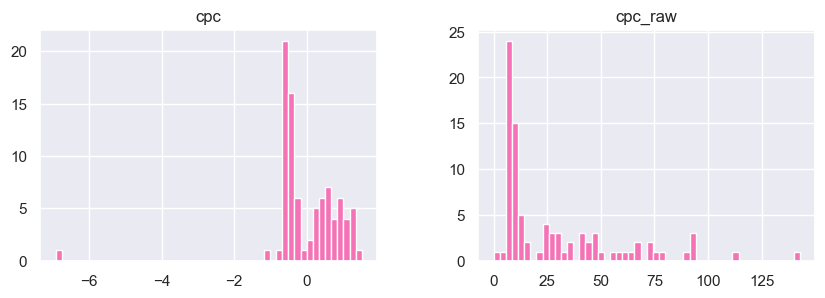

In [6]:
# Parameters ----------------------------------------------------------
index_col = ['asset_id']
norm_metric = True
print_metric = True
transform_type = 'log'
lmbda = 0
transform_coef = 1e-3
#------------------------------------------------------------------------------------

metrics = lasso.process_metrics(df, index_col, metric, transform_type, transform_coef, lmbda=lmbda, norm_metric=norm_metric,
                                print_metric=print_metric, figsize=(10,3))

### Preprocessing data

In [7]:
# PARAMETROS MODIFICABLES ----------------------------------------------------------

date_col = 'created_time'
objective_col = 'campaign_objective'
tag_type_col = 'tag_type'
tag_name_col = 'tag_name'
tag_id_col = 'tag_id'

ad_date, objectives, tags, tags_freq = lasso.preprocess_lasso(df, index_col, date_col, objective_col,
                                                              metrics, tag_type_col, tag_name_col, tag_id_col)

tags_aux = tags.copy()
tags_aux.columns = tags_aux.columns.droplevel()
tags_aux = tags_aux.loc[:,~tags_aux.columns.duplicated()]

¡Preprocess Lasso finished succesfully! Returning ad_date, objectives, tags and tags_freq.


## SHAP

In [8]:
model = LGBMRegressor(boosting_type='gbdt',
                              max_depth=3,
                              n_estimators=200,
                              learning_rate=0.4,
                              objective='mse',
                              n_jobs=-1, random_state=0)

model.fit(X=tags_aux, y=metrics[metric].fillna(0))

explainer = shap.Explainer(model, tags_aux)
shap_values = explainer(tags_aux)

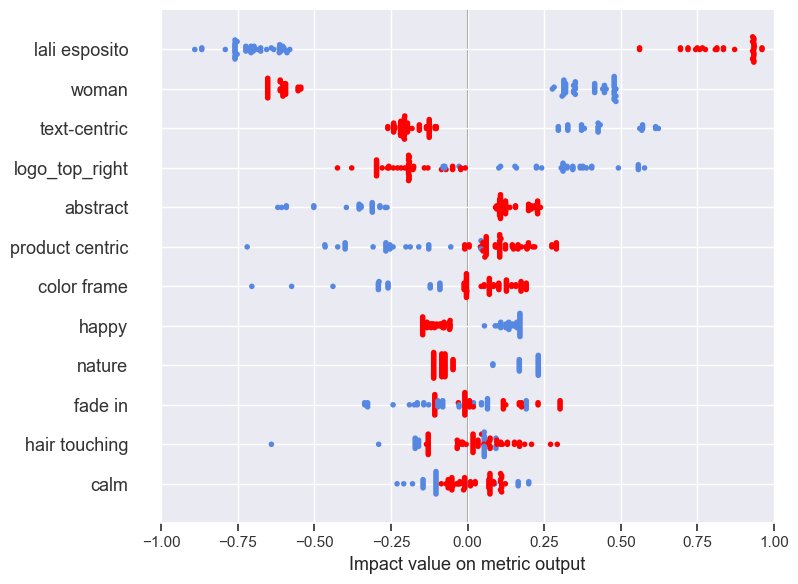

In [9]:
#colors = [(204/255, 0, 0), (0, 0, 204/255)]
colors = [(1, 0, 0), (86/255, 135/255, 225/255)]
n_bin = 100
cmap_parameter = LinearSegmentedColormap.from_list(name='name_list', colors=colors, N=n_bin)
#plt.figure(facecolor='white')
#plt.style.use('seaborn-whitegrid')
shap.summary_plot(shap_values, tags_aux, plot_type="dot", max_display=12, plot_size=(8,6), show=False, cmap=cmap_parameter, color_bar=False)
plt.xlim(-1,1)
plt.xlabel('Impact value on metric output')
#plt.savefig(f'Img/beeswarm_for_{metric}.png')
plt.show()

In [44]:
#list_columns = ['woman', 'fade in', 'hair touching']
#list_index = []
#for i,e in enumerate(shap_values.feature_names):
#    if e in list_columns:
#        list_index.append(i)
#
#tags_aux = tags_aux.drop(columns=list_columns)
#
#for i in list_index:
#    del shap_values.feature_names[i]
#
#shap_values.values = np.delete(shap_values.values, list_index, axis=1)
#shap_values.data = np.delete(shap_values.data, list_index, axis=1)

In [45]:
shap_values.values.shape

(87, 386)

- CTR: 1e-3
- CPC: 1e-2
- VTR: 1e-3
- AdrecallSScore: 1e-2
- bai: 1e-2

HAIRCARE:
- adrecallScore: 1e-2
- bai: 1e-2


dejar tag types de logos para ctr,cpc y vtr, no para adrecall y bai. Dejar no person

In [46]:
def hex_to_rgb(hex_color):
  hex_color = hex_color.lstrip('#')
  return [int(hex_color[i:i+2], 16) for i in range(0, 6, 2)]

hex_to_rgb('#5687c0')

[86, 135, 192]

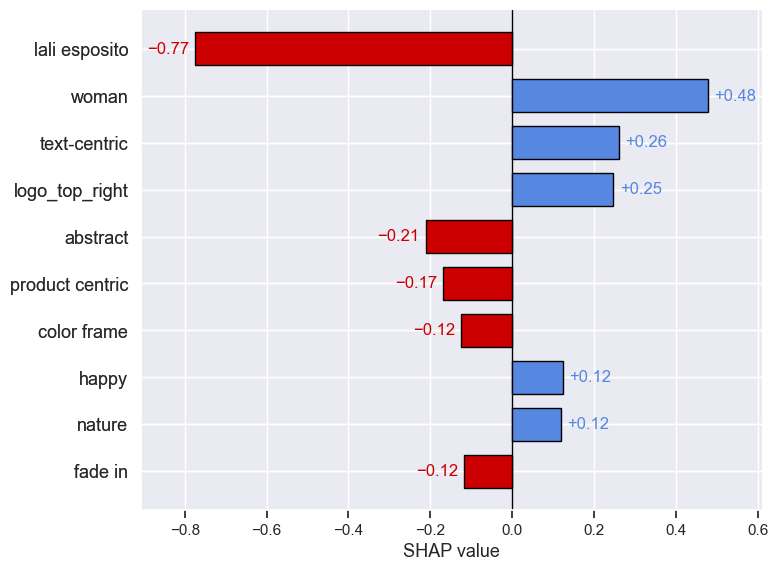

In [22]:
#(86/255, 135/255, 225/255)

shap_values.values[0] = shap_results.score.values
shap.plots.bar(shap_values[0], neg_color='#cc0000', pos_color='#5687E1', max_display=10, show_sum_of_features=False, edge_color='black')

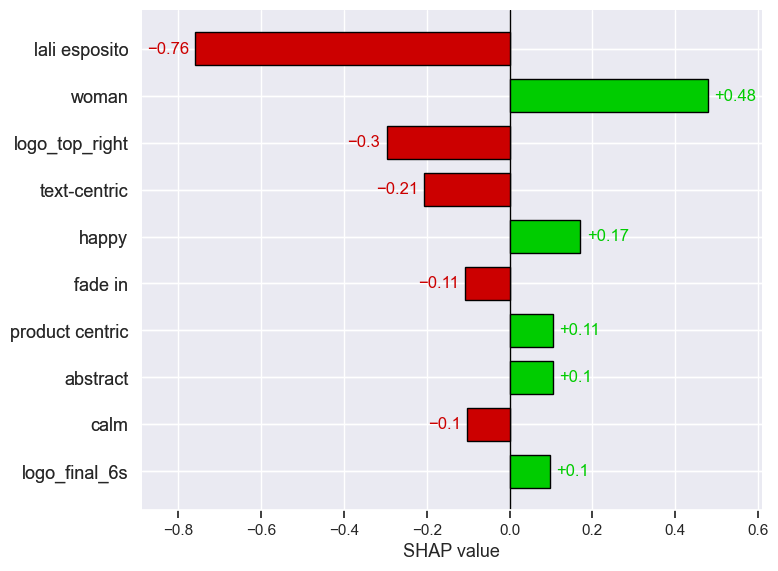

In [10]:
shap.plots.bar(shap_values[0], neg_color='#cc0000', pos_color='#00cc00', max_display=10, show_sum_of_features=False, edge_color='black')

Modificaciones en _bar.py:
- add parameter: show_sum_of_features
- add parameter: edge_color

En boruta sharp:
#from sklearn.datasets import load_breast_cancer, load_boston

In [11]:
tags_freq = tags.sum(0).reset_index().rename(columns={'tag_type':'tag_group', 'tag_name':'tag', 0:'usage_frequency'})
tags_freq["usage_frequency"] = tags_freq.usage_frequency / len(tags)

In [12]:
tags_score_per_asset = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
tags_score_per_asset['asset_id'] = tags_aux.reset_index().asset_id.copy()

In [13]:
list_of_mean_tags = []
for col in tags_aux.columns:
    tag_mean = tags_aux[col].loc[tags_aux[col]==1].reset_index().drop(columns={col}).merge(tags_score_per_asset[[col, 'asset_id']], on='asset_id', how='inner').mean()[0]
    list_of_mean_tags.append(tag_mean)

data = {'tag': tags_aux.columns, 'tag_mean': list_of_mean_tags}

df_sign = pd.DataFrame(data)

In [14]:
shap_results = pd.DataFrame({'score':tags_score_per_asset.drop(columns={'asset_id'}).abs().mean()})
shap_results = shap_results.reset_index().rename(columns={'index':'tag'})

In [15]:
for i,value in enumerate(df_sign.tag_mean):
    if value<0:
        shap_results['score'][i] = shap_results['score'][i]*(-1)

In [16]:
shap_values[0].values = shap_results.score.values

In [ ]:
shap_results.score.values

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.08309663,  0.        ,  0.        ,  0.        ,
        0.12324016, -0.77395648,  0.        ,  0.        ,  0.        ,
        0.        , -0.21133015,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [ ]:
shap_values.values[0] = shap_results.score.values
shap.plots.bar(shap_values[0], neg_color='#cc0000', pos_color='#00cc00', max_display=10, show_sum_of_features=False, edge_color='black')

In [ ]:
A =

In [ ]:
shap_results = pd.merge(shap_results, tags_freq, how='inner', on='tag')
shap_results['period'] = 'all'
shap_results['metric'] = metric

In [ ]:
shap_results.to_csv(f'results/results_for_{metric}.csv', index=False)

In [ ]:
#assets_carrousel = pd.read_csv('data/assets_id_carrusel.csv')
#df_aux = df.loc[df.tag_name=='fashion']
#100*df_aux.loc[df_aux.asset_id.isin(assets_carrousel.asset_id)].asset_id.nunique()/df_aux.asset_id.nunique()

#shap_results['carrousel_percentage'] = ''
#for i,tagg in enumerate(shap_results.tag.values):
#    df_aux = df.loc[df.tag_name==tagg]
#    shap_results.loc[i, 'carrousel_percentage'] = np.round(100*df_aux.loc[df_aux.asset_id.isin(assets_carrousel.asset_id)].asset_id.nunique()/df_aux.asset_id.nunique(),1)

#shap_results_filter = shap_results.loc[shap_results.score.abs()>0.05]
#shap_results_filter = shap_results_filter.reset_index()

In [ ]:
shap_results.sort_values('score', ascending=False)

,tag,score,tag_group,usage_frequency,period,metric
365,woman,0.199108,LABEL,0.679487,all,brandAssociationIndex
252,product layout,0.124561,LABEL,0.346154,all,brandAssociationIndex
6,calm,0.099167,FACE,0.346154,all,brandAssociationIndex
0,chrysti ane,0.000000,CELEBRITY,0.025641,all,brandAssociationIndex
243,pattern,0.000000,LABEL,0.089744,all,brandAssociationIndex
...,...,...,...,...,...,...
16,abstract,-0.138353,LABEL,0.307692,all,brandAssociationIndex
197,light background,-0.235254,LABEL,0.487179,all,brandAssociationIndex
118,fade in,-0.238989,LABEL,0.487179,all,brandAssociationIndex
11,lali esposito,-0.244675,FACE,0.615385,all,brandAssociationIndex


In [ ]:
#---------CTR----------------------------------
#shap_results_filter.loc[(shap_results_filter.tag=='clean') |
#                        (shap_results_filter.tag=='logo_first_10pct') |
#                        (shap_results_filter.tag=='hygienics') |
#                        (shap_results_filter.tag=='fashion') |
#                        (shap_results_filter.tag=='female') |
#                        (shap_results_filter.tag=='illustration') |
#                        (shap_results_filter.tag=='calm') |
#                        (shap_results_filter.tag=='indoors') |
#                        (shap_results_filter.tag=='clothing') |
#                        (shap_results_filter.tag=='outdoors') |
#                        (shap_results_filter.tag=='logo_top_right') |
#                        (shap_results_filter.tag=='business') |
#                        (shap_results_filter.tag=='logo_final_6s') |
#                        (shap_results_filter.tag=='adult') |
#                        (shap_results_filter.tag=='paper')].reset_index(drop=True).sort_values('carrousel_percentage', ascending=False)

In [ ]:
#---------CPC----------------------------------
#shap_results_filter.loc[(shap_results_filter.tag=='lali espsito') |
#                        (shap_results_filter.tag=='merchandise') |
#                        (shap_results_filter.tag=='logo_top_right') |
#                        (shap_results_filter.tag=='design') |
#                        (shap_results_filter.tag=='fashion') |
#                        (shap_results_filter.tag=='logo_first_10pct') |
#                        (shap_results_filter.tag=='25-34') |
#                        (shap_results_filter.tag=='clothing') |
#                        (shap_results_filter.tag=='business') |
#                        (shap_results_filter.tag=='no person') |
#                        (shap_results_filter.tag=='people') |
#                        (shap_results_filter.tag=='portrait') |
#                        (shap_results_filter.tag=='outdoors') |
#                        (shap_results_filter.tag=='indoors') |
#                        (shap_results_filter.tag=='logo_bottom_left')].reset_index(drop=True).sort_values('carrousel_percentage', ascending=False)

In [ ]:
#---------VTR----------------------------------
#shap_results_filter.loc[(shap_results_filter.tag=='logo_top_right') |
#                        (shap_results_filter.tag=='logo_first_10pct') |
#                        (shap_results_filter.tag=='illustration') |
#                        (shap_results_filter.tag=='business') |
#                        (shap_results_filter.tag=='adult') |
#                        (shap_results_filter.tag=='no person') |
#                        (shap_results_filter.tag=='outdoors') |
#                        (shap_results_filter.tag=='female') |
#                        (shap_results_filter.tag=='nature') |
#                        (shap_results_filter.tag=='indoors') |
#                        (shap_results_filter.tag=='human face') |
#                        (shap_results_filter.tag=='portrait') |
#                        (shap_results_filter.tag=='clothing') |
#                        (shap_results_filter.tag=='fashion') |
#                        (shap_results_filter.tag=='logo_first_50pctg')].sort_values('carrousel_percentage', ascending=False)

In [ ]:
#---------adrecallScore----------------------------------
#shap_results_filter.loc[(shap_results_filter.tag=='female') |
#                        (shap_results_filter.tag=='adult') |
#                        (shap_results_filter.tag=='outdoors') |
#                        (shap_results_filter.tag=='business') |
#                        (shap_results_filter.tag=='human face') |
#                        (shap_results_filter.tag=='label') |
#                        (shap_results_filter.tag=='fashion') |
#                        (shap_results_filter.tag=='nature') |
#                        (shap_results_filter.tag=='indoors') |
#                        (shap_results_filter.tag=='abstract') |
#                        (shap_results_filter.tag=='lali espsito') |
#                        (shap_results_filter.tag=='25-34') |
#                        (shap_results_filter.tag=='paper') |
#                        (shap_results_filter.tag=='ilustration') |
#                        (shap_results_filter.tag=='happy')].sort_values('carrousel_percentage', ascending=False)

In [ ]:
#---------Bai----------------------------------
#shap_results_filter.loc[(shap_results_filter.tag=='human face') |
#                        (shap_results_filter.tag=='clothing') |
#                        (shap_results_filter.tag=='female') |
#                        (shap_results_filter.tag=='people') |
#                        (shap_results_filter.tag=='woman') |
#                        (shap_results_filter.tag=='adult') |
#                        (shap_results_filter.tag=='fashion') |
#                        (shap_results_filter.tag=='indoors') |
#                        (shap_results_filter.tag=='label') |
#                        (shap_results_filter.tag=='business') |
#                        (shap_results_filter.tag=='happy') |
#                        (shap_results_filter.tag=='text') |
#                        (shap_results_filter.tag=='lali espsito') |
#                        (shap_results_filter.tag=='calm') |
#                        (shap_results_filter.tag=='outdoors')].sort_values('carrousel_percentage', ascending=False)

In [ ]:
#shap_results_filter = shap_results_filter.loc[shap_results_filter.score!=0]

In [ ]:
#results = shap_results_filter.loc[(shap_results_filter.period=='all')]
#
#results["Score sign"] = results["score"].apply(lambda x: "Positive" if x > 0 else "Negative")
#results.rename(columns={"score":"Score", "metric":"Metric", "tag_group":"Tag type", "tag":"Tag name"}, inplace=True)
#results["Tag name"] = results["Tag name"].apply(lambda x: x.replace("excessive ice", "icee"))
#results.head(5)

In [ ]:
def mean_difference(tag_group, tag, metric, sufix):
    ads_with_tag = tags.index[tags[tag_group, tag]==1]
    mean_with =    metrics.loc[ metrics.index.isin(ads_with_tag), metric+sufix].mean()
    mean_without = metrics.loc[~metrics.index.isin(ads_with_tag), metric+sufix].mean()
    return mean_with / mean_without - 1

In [ ]:
#results["Tag impact"] = results.apply(lambda x: mean_difference(x["Tag type"], x["Tag name"], x["Metric"], ""), axis=1)
##results["Tag impact trans"] = results.apply(lambda x: mean_difference(x["Tag type"], x["Tag name"], x["Metric"], ""), axis=1)
#results

In [ ]:
#px.box(results, x="Metric", y="Tag impact", color="Score sign", points="all", title="Lasso score distribution by metric")

In [ ]:
# mann whitney U test mannwhitneyu
#from scipy.stats import ttest_ind
#for metric in results["Metric"].unique():
#    tmp = results[results["Tag impact"].notna()]
#    print(metric)
#    res= ttest_ind(
#            tmp[(tmp["Score sign"]=="Negative") & (tmp["Metric"]==metric)]["Tag impact"],
#            tmp[(tmp["Score sign"]=="Positive") & (tmp["Metric"]==metric)]["Tag impact"],
#            alternative="less"
#        )
#    mean_negative = tmp[(tmp["Score sign"]=="Negative") & (tmp["Metric"]==metric)]["Tag impact"].mean()
#    mean_positive = tmp[(tmp["Score sign"]=="Positive") & (tmp["Metric"]==metric)]["Tag impact"].mean()
#    # print mean difference
#    print(f"{res.pvalue} {abs(mean_positive - mean_negative)/abs(mean_negative)*100:.1f}%")

In [ ]:
#ca_plt.gg_scatterplot_install()

In [ ]:
#ca_plt.gg_scatterplot_2(shap_results_filter, metric, period='all', y_max=shap_results_filter.score.max()+0.01, y_min=shap_results_filter.score.min()-0.01, tags_plot=[],
#                        y_title='Estimated\nregression\ncoefficient',
#                        x_title='Usage frequency',n_tags=15,save=False,filename=f'Img/scatterplot_for_{metric}.png',
#                        width=900,height=600,plot=True, label_size=4, freq=0.5,y_ext=0.02,
#                        symbol_size=3,
#                        metrics_positive=['ctr','vvr','likes','shares','comments','vtr', 'BAI', 'MEMORABILITY_ADRECALLPROB', 'adrecallScore'],
#                        metrics_negative=['cpc','cpm','cpmr','cpv'],
#                        colors=[],legend_labels=[],shapes=[20,17,8,18,12,13,9,1,2])

## Boruta shap

In [ ]:
%%time
model = LGBMRegressor(boosting_type='gbdt',
                              max_depth=3,
                              n_estimators=200,
                              learning_rate=0.4,
                              objective='mse',
                              n_jobs=-1, random_state=0)

# Feature selection with BorutaShap for regression
Feature_Selector = BorutaShap(model=model,   
                              importance_measure='shap', 
                              classification=False)

Feature_Selector.fit(X=tags_aux, y=metrics[metric].fillna(0), n_trials=200, random_state=2)

#Feature_Selector.accepted
#Feature_Selector.shap_values

# Feature importance plot
#Feature_Selector.plot(which_features='accepted', figsize=(24,6), X_size=15)

# Select the best feature subset
X_fil = Feature_Selector.Subset()

  0%|          | 0/200 [00:00<?, ?it/s]

7 attributes confirmed important: ['text', 'logo_center', 'logo_top_right', 'clothing', 'people', 'lali espsito', 'outdoors']
384 attributes confirmed unimportant: ['motion', 'shape', 'art', 'drop', 'sitting', 'splat', 'cute', 'logo_bottom_left', 'dancer', 'headshot', 'love', 'care', 'painting', 'hairdo', 'fern', 'individuality', 'pool', 'desktop', 'horizontal plane', 'page', 'hygiene', 'happiness', 'tag', 'market', 'artistic', 'enjoyment', 'silhouette', 'pattern', 'management', 'drink', 'business', 'religion', 'bathroom', 'fashion', 'kimono', 'mask', 'frosty', 'confused', 'summer', 'aquatic', 'illustration', 'h2o', 'label', 'still life', 'disgusted', 'service', 'human face', 'purity', 'lilac', 'sphere', 'singer', 'logo_bottom', 'health', 'shampoo', 'dawn', 'round out', 'booklet', 'hotel', 'relaxation', 'graphic', 'logo_top', 'food', 'burnt', 'paper', 'city', 'design', 'lavender', 'invention', 'fun', 'abstract', 'communication', 'luxury', 'cover', 'actress', 'advertising', 'scribble', 

In [ ]:
important_confirmed_attriubutes = Feature_Selector.accepted + Feature_Selector.tentative

print(important_confirmed_attriubutes)

['text', 'logo_center', 'logo_top_right', 'clothing', 'people', 'lali espsito', 'outdoors']


In [ ]:
a = 

SyntaxError: invalid syntax (2792523948.py, line 1)

## Lasso model

In [ ]:
# PARAMETROS MODIFICABLES ----------------------------------------------------------

date_col = 'created_time'
objective_col = 'objective'
tag_type_col = 'tag_type'
tag_name_col = 'tag_name'
tag_id_col = 'tag_id'

ad_date, objectives, tags, tags_freq = lasso.preprocess_lasso(df, index_col, date_col, objective_col,
                                                              metrics, tag_type_col, tag_name_col, tag_id_col)

¡Preprocess Lasso finished succesfully! Returning ad_date, objectives, tags and tags_freq.


training model: cpc for deltatime: all and objective: None
------> OK
training model: cpc_raw for deltatime: all and objective: None
------> OK


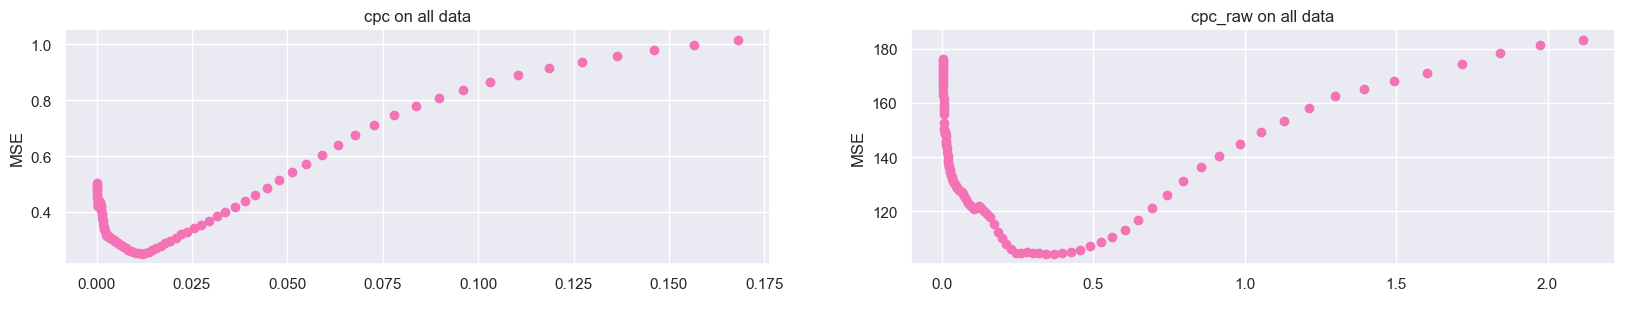

In [ ]:
# SETTING WEIGHTS
weight = df[['asset_id', 'carrusel_coef']].groupby('asset_id').first().iloc[:,0]
#----------------------------------


results = lasso.train_lasso(df, ad_date, objectives, tags, tags_freq, metrics, weight=weight,
                            use_weight=True, use_objective=False, use_time=False, 
                            delta_days=180, nfolds=10, iterations=10000)

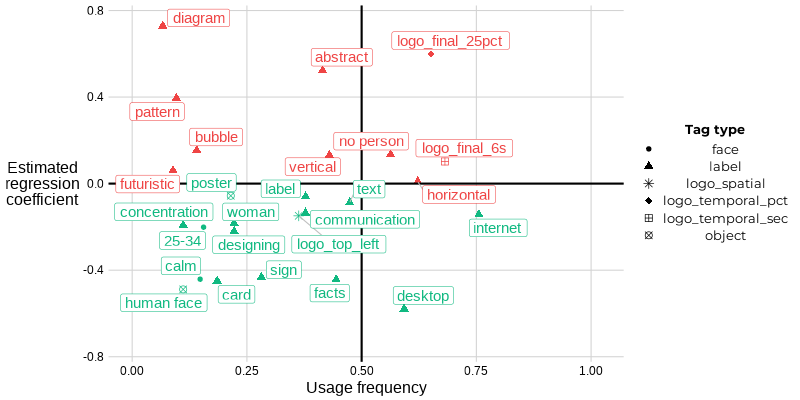

In [ ]:
ca_plt.gg_scatterplot_2(results,metric,period='all',y_max=None,y_min=None,tags_plot=[],\
    y_title='Estimated\nregression\ncoefficient',\
        x_title='Usage frequency',n_tags=15,save=False,filename='scatterplot.png',\
            width=900,height=600,plot=True, label_size=4, freq=0.5,y_ext=0.02,\
                symbol_size=3,\
                    metrics_positive=['ctr','vvr','likes','shares','comments','vtr'],\
                        metrics_negative=['cpc','cpm','cpmr','cpv'],
                        colors=[],legend_labels=[],shapes=[20,17,8,18,12,13])

In [ ]:
#import matplotlib
#import matplotlib.pyplot as plt
#
## Default SHAP colors
#default_pos_color = "#ff0051"
#default_neg_color = "#008bfb"
## Custom colors
#positive_color = "#00cc00"
#negative_color = "#cc0000"
## Plot Waterfall Plot
#shap.plots.waterfall(shap_values[0], show = False)
## Change the colormap of the artists
#for fc in plt.gcf().get_children():
#    for fcc in fc.get_children():
#        if (isinstance(fcc, matplotlib.patches.FancyArrow)):
#            if (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_pos_color):
#                fcc.set_facecolor(positive_color)
#            elif (matplotlib.colors.to_hex(fcc.get_facecolor()) == default_neg_color):
#                fcc.set_color(negative_color)
#        elif (isinstance(fcc, plt.Text)):
#            if (matplotlib.colors.to_hex(fcc.get_color()) == default_pos_color):
#                fcc.set_color(positive_color)
#            elif (matplotlib.colors.to_hex(fcc.get_color()) == default_neg_color):
#                fcc.set_color(negative_color)
#plt.show()